In [1]:
import networkx as nx

In [2]:
#substrate graph 

In [3]:
Gs = nx.Graph()
Gs.add_nodes_from([1,2,3,4,5,6],cpu=20,st=20)
Gs.nodes[3]['st']=17
Gs.nodes[4]['st']=16
Gs.nodes[5]['st']=15
#add edges
Gs.add_edges_from([(1, 2),(1,6),(2,3),(2,5),(3,4),(4,5),(5,6)], weight=20 )

{(1, 2): Text(-0.18756902480768206, -0.4639177779264419, '20'),
 (1, 6): Text(0.015264156380735083, -0.9060918133922353, '20'),
 (2, 3): Text(-0.13960456808223426, 0.47553848735739496, '20'),
 (2, 5): Text(-0.7947822464990619, 0.49443673579820185, '20'),
 (3, 4): Text(0.779518090118327, 0.41165507759403347, '20'),
 (4, 5): Text(0.12434041170149918, 0.43055332603484037, '20'),
 (5, 6): Text(-0.5919490653106448, 0.052262700332408374, '20')}

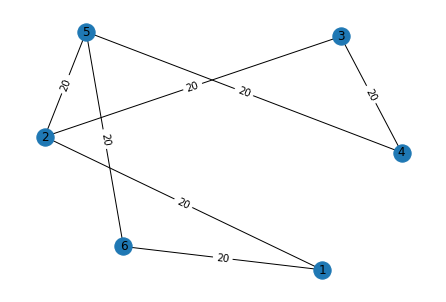

In [4]:
#nx.draw(Gs, with_labels=True, font_weight='bold')

pos = nx.spring_layout(Gs, k=20)  # For better example looking
nx.draw(Gs, pos, with_labels=True)
labels = {e: Gs.edges[e]['weight'] for e in Gs.edges}
nx.draw_networkx_edge_labels(Gs, pos, edge_labels=labels)

In [5]:
#request graph

In [6]:
Gv = nx.Graph()
Gv.add_node(1,cpu=5,st=5)
Gv.add_node(2,cpu=4,st=4)
Gv.add_node(3,cpu=3,st=3)
#add edges
Gv.add_edges_from([(1,2),(2,3),(3,1)],weight=2)

{(1, 2): Text(-0.022764796763793282, 0.49999999999999994, '2'),
 (1, 3): Text(0.4750026783500723, -0.2376196620492892, '2'),
 (2, 3): Text(-0.45223788158627914, -0.26238033795071086, '2')}

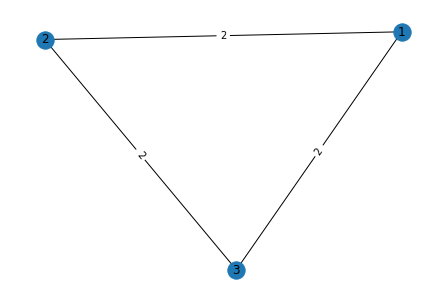

In [7]:
pos = nx.spring_layout(Gv, k=20)  # For better example looking
nx.draw(Gv, pos, with_labels=True)
labels = {e: Gv.edges[e]['weight'] for e in Gv.edges}
nx.draw_networkx_edge_labels(Gv, pos, edge_labels=labels)

In [8]:
GVs = [Gv]

In [9]:
#Node Rank Metric

In [10]:
def NRM(network):
    temp = []
    for node in network.nodes(data=True):
        sum_edge = 0
        for edge in network.edges(node[0],data=True):
            sum_edge = sum_edge + edge[2]['weight']
        met = (node[1]['cpu']+node[1]['st'])*(sum_edge)
        temp.append((met,node[0]))
    return sorted(temp,reverse=True)

In [11]:
def node_ranking(fGv):
    met_s = NRM(Gs)
    met_v = NRM(fGv)
    mapped = []
    mapping = []
    for node_v in met_v:
        for node in met_s:
            if (node[1] not in mapped) and Gs.nodes(data=True)[node[1]]['cpu']>=fGv.nodes(data=True)[node_v[1]]['cpu'] and Gs.nodes(data=True)[node[1]]['st']>=fGv.nodes(data=True)[node_v[1]]['st']:
                mapped.append(node[1])
                mapping.append({'Nv':node_v[1],'Ns':node[1]})
                break
    if(len(met_v)==len(mapped)):
        return True, mapping
    return False, mapping

In [12]:
# def link_mapping(Vmap,fGv):
#     edges=sorted(fGv.edges(data=True), key=lambda t: t[2].get('weight', 1), reverse=True)
#     mapping = []
#     name_indexer = dict((p['Nv'], i) for i, p in enumerate(Vmap))
#     for edge in edges:
#         n1 = Vmap[name_indexer.get(edge[0])]['Ns']
#         n2 = Vmap[name_indexer.get(edge[1])]['Ns']
#         flag = 0
#         rmv = []
#         while len(Gs.edges()):
#             small = [-1,-1,1000000]
#             path = nx.dijkstra_path(Gs,n1,n2,weight = 'weight')
            
#             #if no path exist
#             if(len(path)==0):
#                 return False
            
#             for i in range(1,len(path)):
#                 #condition to check if BW(Ev) <= BW(Mapping(Ns1,Ns2))
#                 if Gs[path[i-1]][path[i]]['weight']>=edge[2]['weight']:
#                     Gs[path[i-1]][path[i]]['weight'] = Gs[path[i-1]][path[i]]['weight'] - edge[2]['weight']
#                     flag = 1
#                     mapping.append([path[i-1],path[i],edge])
#                     break
#                 if(small[2]>Gs[path[i-1]][path[i]]['weight']):
#                     small[0] = path[i-1]
#                     small[1] = path[i]
#                     small[2] = Gs[path[i-1]][path[i]]['weight']
#             if(flag == 1):
#                 break
#             rmv.append(small)
#             Gs.remove_edge(small[0],small[1])
        
#         #Add the removed edges
#         for i in rmv:
#             Gs.add_edge(i[0],i[1],weight=i[2])
            
#         if(flag == 0):
#             return False, []
    
#     return True, mapping

In [13]:
def link_mapping(Vmap,fGv):
    edges=sorted(fGv.edges(data=True), key=lambda t: t[2].get('weight', 1), reverse=True)
    mapping = []
    name_indexer = dict((p['Nv'], i) for i, p in enumerate(Vmap))
    for edge in edges:
        n1 = Vmap[name_indexer.get(edge[0])]['Ns']
        n2 = Vmap[name_indexer.get(edge[1])]['Ns']
        flag = 0
        rmv = []
        for e in list(Gs.edges(data=True)):
            if e[2]['weight']<edge[2]['weight']:
                rmv.append(e)
                Gs.remove_edge(e[0],e[1])
        
        #Find the shortest path
        path = nx.dijkstra_path(Gs,n1,n2,weight = 'weight')
        
        #Add the removed edges
        for ix in rmv:
            Gs.add_edge(ix[0],ix[1],weight=ix[2])
            
        if(len(path)==0):
            return False, []
        
        mapping.append([edge,path])
    
    for p in mapping: 
        for i in range(1,len(p[1])):
            Gs[p[1][i-1]][p[1][i]]['weight'] = Gs[p[1][i-1]][p[1][i]]['weight'] - p[0][2]['weight']
    return True, mapping

In [14]:
def NRM_VNE(Gvs):
    rejected = 0
    accepted = 0
    for NRM_Gv in Gvs:
        flag, Vmap = node_ranking(NRM_Gv)
        if(not flag):
            print('Not mapped')
            rejected = rejected + 1
            continue
        flag, Emap = link_mapping(Vmap,NRM_Gv)
        if(not flag):
            print('Not mapped')
            rejected = rejected + 1
            continue
        accepted = accepted +1
        #updating the Substrate graph CPU and Storage
        for node in Vmap:
            Gs.nodes(data=True)[node['Ns']]['cpu'] = Gs.nodes(data=True)[node['Ns']]['cpu'] - NRM_Gv.nodes(data=True)[node['Nv']]['cpu']
            Gs.nodes(data=True)[node['Ns']]['st'] = Gs.nodes(data=True)[node['Ns']]['st'] - NRM_Gv.nodes(data=True)[node['Nv']]['st']
    print('Acceptance Ratio:' + str(accepted/len(Gvs)))
    print(Vmap)
    print(Emap)

In [15]:
NRM_VNE(GVs)

Acceptance Ratio:1.0
[{'Nv': 1, 'Ns': 2}, {'Nv': 2, 'Ns': 5}, {'Nv': 3, 'Ns': 6}]
[[(1, 2, {'weight': 2}), [2, 5]], [(1, 3, {'weight': 2}), [2, 1, 6]], [(2, 3, {'weight': 2}), [5, 6]]]


{(1, 2): Text(0.6504966464253226, 0.5090486398498062, '18'),
 (1, 6): Text(-0.3138918721218645, 0.3891145921173493, '18'),
 (2, 3): Text(0.1807242967606238, 0.4500476546723403, '20'),
 (2, 5): Text(0.7892281753228312, -0.3324323574318931, '18'),
 (3, 4): Text(-0.47533630320096676, -0.0566822346854563, '20'),
 (4, 5): Text(0.1331675753612407, -0.8391622467896898, '20'),
 (5, 6): Text(-0.17516034322435586, -0.45236640516435, '18')}

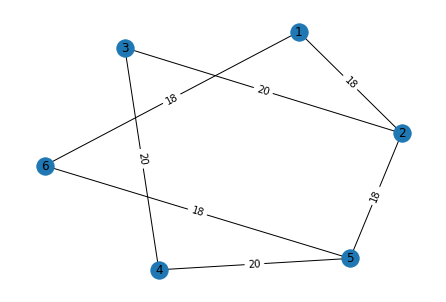

In [16]:
pos = nx.spring_layout(Gs, k=20)  # For better example looking
nx.draw(Gs, pos, with_labels=True)
labels = {e: Gs.edges[e]['weight'] for e in Gs.edges}
nx.draw_networkx_edge_labels(Gs, pos, edge_labels=labels)